In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import io
import re
from scipy.sparse import hstack
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, Embedding, Dense, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import binary_crossentropy 
from tensorflow_addons.metrics import F1Score
from keras.initializers import Constant
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


L'objectif de notre projet est de classifier des tweets en deux catégories selon si ils font référence à des désastres ou non.

# 0. Les données



Commençons par charger les données que nous souhaitons étudier. Nous traiterons une base de données contenant des tweets. 

Commençons par charger nos données :

In [ ]:
train = files.upload()

Saving train.csv to train.csv


On charge les données dans des data frames de pandas pour pouvoir les exploiter au mieux.


In [ ]:
df_train = pd.read_csv(io.StringIO(train['train.csv'].decode('utf-8')))

Regardons rapidement de quoi sont composées nos données :

In [ ]:
df_train.head

<bound method NDFrame.head of          id keyword  ...                                               text target
0         1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1         4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2         5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3         6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4         7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1
...     ...     ...  ...                                                ...    ...
7608  10869     NaN  ...  Two giant cranes holding a bridge collapse int...      1
7609  10870     NaN  ...  @aria_ahrary @TheTawniest The out of control w...      1
7610  10871     NaN  ...  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...      1
7611  10872     NaN  ...  Police investigating after an e-bike collided ...      1
7612  10873     NaN  ...  The Latest: More Homes Razed by

Nos données comportent 4 colonnes. La première contient un identifiant unique du tweet (que nous ne traitons pas). La seconde contient un mot clé associé au tweet, ou bien la valeur NaN. La troisième contient le tweet à proprement parlé et la 4ème une valeur binaire qui indique si le tweet annonce une catastrophe qui s'est produite (valeur 1) ou si ce n'est pas le cas (valeur 0).

A titre d'exemple, montrons des tweets qui ne sont PAS des tweets de catastrophes :

In [ ]:
df_train[df_train.target == 0].text

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

On remarque rapidement que parmis les tweets qui ne parlent pas des catastrophes, certains sont évidents comme le premier tweet "What's up man?" et d'autres le sont moins comme le numéro 7593 qui commence par "I just heard a really loud bang and everyone...". 

Pour pouvoir effectuer nos testes, nous allons découper nos données en $2$ ensembles d'entrainement et de validation, avec les proportions $80$ - $20$.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["target"], test_size=0.2, random_state=42)

# 1. Les premiers modèles



## Vectorisation des données 


Nous allons implémenter des premiers modèles pour classifier nos tweets. Nous allons vectoriser dans un premier temsp nos tweets en utilisant des modèles de types "Bag Of Words" qui retirent l'ordre des mots d'un tweet pour ne se concentrer que sur l'occurence des mots dans le tweet ainsi que dans le corpus qui le contient. 
Plus d'information sur le modèle Bag Of Words [ici](https://www.researchgate.net/publication/226525014_Understanding_bag-of-words_model_A_statistical_framework) 

Commençons par extraire les features et changer la représentation de nos bases de données. Nos tweets, des chaines de caractères, sont transformés en une représentation vectorielle dans train_vectors et test_vectors en utilisant les méthodes CountVectorizer et TfidVectorizer. Nous détaillerons ces méthodes dans la suite du document. Nous mentionnons seulement à ce stade que TfidVectorizer est une version améliorée de CountVectorizer, et qu'ils permettent de transformer une chaine de caractères en un vecteur de réels.

In [ ]:
### Fonction d'affichage de la matrice de confusion ###
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    """ Fonction d'affichage de la matrice de confusion """
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
### On vectorise nos données d'entrée ###
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(X_train)
test_vectors = count_vectorizer.transform(X_val)

tfid_vectorizer = TfidfVectorizer()
tfid_vectorizer.fit(X_train)
train_vectors_tfid = tfid_vectorizer.transform(X_train)
val_vectors_tfid = tfid_vectorizer.transform(X_val)

## Ridge Classification

Construisons un modèle de régression linéaire simple, celui de Ridge avec une pénalisation L2 pour commencer à classifer notre corpus. Ce modèle est simple et rapidement entrainable avec une pénalisation L2 ce qui a motivé notre choix. On trouve un fonctionnement détaillé de l'algorithme [ici](https://amstat.tandfonline.com/doi/ref/10.1080/00401706.1970.10488634?scroll=top#.XsOprhY6_JF) 

In [ ]:
### On entraine notre classifier Ridge ###
clf_ridge = linear_model.RidgeClassifier(alpha=1)

In [ ]:
### On affiche l'accuracy avec entrainement sur les features CountVectorizer ###
scores = cross_val_score(clf_ridge, train_vectors, y_train, cv=2, scoring="accuracy")
scores.mean()

0.7627257799671593

In [ ]:
### On affiche l'accuracy avec entrainement sur les features TfidVectorizer ###
scores_tfid = cross_val_score(clf_ridge, train_vectors_tfid, y_train, cv=2, scoring="accuracy")
scores_tfid.mean()

0.7883415435139574

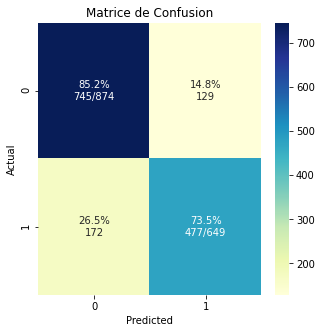

In [ ]:
### On affiche la matrice de confusion ###
clf_ridge = linear_model.RidgeClassifier(alpha=1.606)
clf_ridge.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_ridge.predict(val_vectors_tfid),"Matrice de Confusion")

Etudions maintenant les résultats que nous obtenons. Nous trouvons une précision de 76-78% avec ce modèle sur nos données. Nous remarquons que cette algorithme prédit mieux les tweets qui ne sont **PAS** des catastrophes que les autres au vu de la matrice de confusion. Dans l'ensemble cette algorithme semble très performant pour un premier départ au vu de notre base de données. Il nous reste maintenant à adapter notre paramètre $\alpha$ pour rendre l'algorithme plus performant.

## Boosting trees

On propose maintenant un second modèle qui se base sur une forêt d'arbres de décision que l'on améliore avec une technique de boosting. On retrouve un fonctionnement détaillé de l'algorithme [ici](http://papers.nips.cc/paper/1059-boosting-decision-trees.pdf). L'idée sous-jacente est d'optimiser plusieurs arbres de décision tel que le dernier arbre optimisé prenne en compte les erreurs de l'arbre d'avant. On peut pour cela augmenter le nombre d'arbres dans le processus en faisant varier n_estimators. Plus ce nombre est grand, plus on devrait obtenir de bons résultats (et plus l'algorithme prendra du temps à s'exécuter).

In [ ]:
### On entraine noter AdaBoost sur arbres de décisiosn ###
clf_adatree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=100, max_features = "sqrt"),
                          n_estimators=100, random_state=np.random.RandomState(0))

In [ ]:
### On affiche l'accuracy avec entrainement sur les features CountVectorizer ###
scores = cross_val_score(clf_adatree, train_vectors, y_train, cv=2, scoring="accuracy")
scores.mean()

0.7280788177339901

In [ ]:
### On affiche l'accuracy avec entrainement sur les features TfidVectorizer ###
scores_tfid = cross_val_score(clf_adatree, train_vectors_tfid, y_train, cv=2, scoring="accuracy")
scores_tfid.mean()

0.7073891625615764

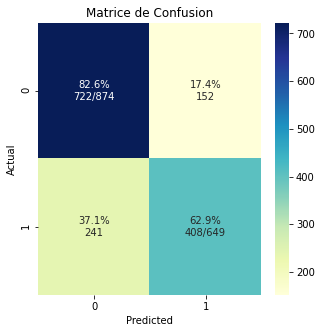

In [ ]:
### On affiche la matrice de confusion ###
clf_adatree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=100, max_features = "sqrt"),
                          n_estimators=100, random_state=np.random.RandomState(0))
clf_adatree.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_adatree.predict(val_vectors_tfid),"Matrice de Confusion")

Les performances de l'algorithme sont correctes mais une amélioration des résultats nécessiteraient d'augmenter le nombre d'arbre à considérer, ce que nous ne souhaitons pas effectuer au vu du temps de calcul assez long. On remarque encore une fois que l'algorithme à plus de difficultés à prédire les tweets de catastrophes que ceux qui n'en sont pas.

## Machine à noyau

On propose un troisième modèle qui utilise les machines à noyaux, aussi connu sous le nom de KSVM. On prend par défaut un noyau Gaussien en se fixant notre paramètre $\gamma$ et on optimise le paramètre de bandes $C$ dont dépend notre noyau. Plus d'informations sur l'algorithme [ici](https://link.springer.com/article/10.1007/s10462-005-9009-3). L'idée sous-jacente est de projeter nos données dans un espace de features de dimension plus élevée pour pouvoir ensuite les séparer, et donc les classifier.

In [ ]:
### On entraine notre KSVM avec noyau gaussien ###
clf_svm = SVC(C=1, kernel="rbf", gamma = "scale", random_state = 1)

In [ ]:
### On affiche l'accuracy avec entrainement sur les features CountVectorizer ###
scores = cross_val_score(clf_svm, train_vectors, y_train, cv=2, scoring="accuracy")
scores.mean()

0.7747126436781608

In [ ]:
### On affiche l'accuracy avec entrainement sur les features TfidVectorizer ###
scores_tfid = cross_val_score(clf_svm, train_vectors_tfid, y_train, cv=2, scoring="accuracy")
scores_tfid.mean()

0.7798029556650246

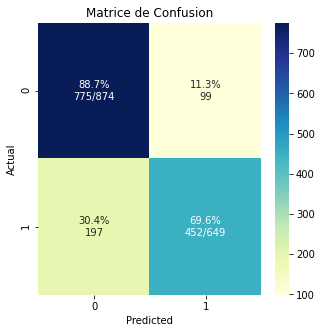

In [ ]:
### On affiche la matrice de confusion ###
clf_svm = SVC(C=1, kernel="rbf", gamma = "scale", random_state = 1)
clf_svm.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_svm.predict(val_vectors_tfid),"Matrice de Confusion")

Les résultats sont globalements satisfaisants mais peuvent être améliorés en trouvant de bons paramètres $C$ ainsi que $\gamma$ adéquats. Encore une fois, l'aspect de la matrice de confusion est similaire aux 2 autres.

## Random Forest

On propose enfin une forêt aléatoire pour résoudre le problème de classification. L'idée de base de cette méthode consiste à prendre plusieurs arbres de décision que l'on entraine en parallèle et de les faire voter pour définir le label d'un tweet. On peut trouver plus d'informations sur l'algorithme et sur le nombre d'arbres à considérer [ici](https://www.researchgate.net/profile/Jose_Baranauskas/publication/230766603_How_Many_Trees_in_a_Random_Forest/links/0912f5040fb35357a1000000/How-Many-Trees-in-a-Random-Forest.pdf).

In [ ]:
### On entraine notre Random Forest ###
clf_forest = RandomForestClassifier(n_estimators=4096, criterion="entropy", max_depth=10)

In [ ]:
### On affiche l'accuracy avec entrainement sur les features CountVectorizer ###
scores = cross_val_score(clf_forest, train_vectors, y_train, cv=2, scoring="accuracy")
scores.mean()

0.645320197044335

In [ ]:
### On affiche l'accuracy avec entrainement sur les features TfidVectorizer ###
scores_tfid = cross_val_score(clf_forest, train_vectors_tfid, y_train, cv=2, scoring="accuracy")
scores_tfid.mean()

0.6456486042692939

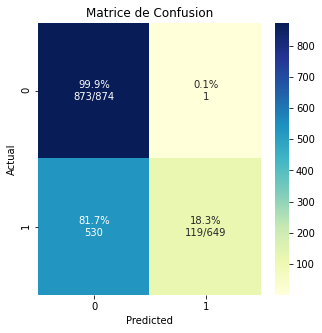

In [ ]:
### On affiche la matrice de confusion ###
clf_forest = RandomForestClassifier(n_estimators=4096, criterion="entropy", max_depth=10)
clf_forest.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_forest.predict(val_vectors_tfid),"Matrice de Confusion")

Les résultats ne sont pas aussi bons que ceux évoqués au début de notre partie. En particulier, cette méthode apprend très bien à classifier les tweets qui ne sont pas des catastrophes  mais peine véritablement à bien classer ceux qui en sont. Le seul moyen d'améliorer les performances de cette algorithme serait d'augmenter la profondeur maximum de chaque arbre ainsi que le nombre d'arbres, ce qui augmente considérablement le temps de calcul. Nous ne chercherons plus dans la suite à améliorer cet algorithme.

## Conclusion sur les modèles

On remarque que nos modèles performent relativement bien sur notre base de données, bien qu'il semble nécéssaire d'améliorer les paramètres associés. Nous nous intéréssons dans la suite à une procédure d'optimisation des hyperparamètres pour deux de nos modèles, les machines à noyaux ainsi que la régression linéaire pénalisée.

Nous remarquons également que les algorithmes sont plus performants sur des features extraites avec la technique TF-IDF utilisée avec Tfidvectorize qu'avec notre première méthode Countvectorizer. Nous décidons donc d'optimiser nos paramètres sur des features extraites avec TF-IDF dans la prochaine partie.

#2. Tuning de nos modèles


## Tuning de Ridge

On se concentre maintenant sur la regression linéaire qui a l'avantage d'être assez rapide. On considère alors la pénalisation L2 qui possède une formule explicite et donc un temps de calcul quasi instantané. On procède par gridsearch.

In [ ]:
parameters = {'alpha':np.arange(0.5,20,0.1)}
ridge = linear_model.RidgeClassifier()
grid_ridge = GridSearchCV(ridge, parameters, scoring="accuracy", cv=2)
grid_ridge.fit(train_vectors_tfid, y_train)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_ridge.best_params_,grid_ridge.best_score_))

Le meilleur paramètre est {'alpha': 1.0999999999999999} pour une précision de 0.7885057471264367


On quadrille la meilleure régularisation possible en réduisant l'ensemble des valeurs.

In [ ]:
parameters = {'alpha':np.arange(0.5,1,0.001)}
ridge = linear_model.RidgeClassifier()
grid_ridge = GridSearchCV(ridge, parameters, scoring="accuracy", cv=2)
grid_ridge.fit(train_vectors_tfid, y_train)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_ridge.best_params_,grid_ridge.best_score_))

Le meilleur paramètre est {'alpha': 0.9630000000000004} pour une précision de 0.7886699507389163


Le meilleur ridge est à priori avec une pénalisation de 0.963 ! Vérifions cela sur nos données de validation.

In [ ]:
### On entraine notre classifier Ridge ###
clf_ridge = linear_model.RidgeClassifier(alpha=0.541)
clf_ridge.fit(train_vectors_tfid, y_train)
print("L'accuracy sur les données de validations est : ",accuracy_score(clf_ridge.predict(val_vectors_tfid), y_val))

L'accuracy sur les données de validations est :  0.7984241628365069


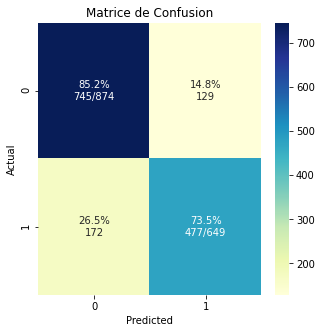

In [ ]:
### On affiche la matrice de confusion ###
clf_ridge = linear_model.RidgeClassifier(alpha=1.606)
clf_ridge.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_ridge.predict(val_vectors_tfid),"Matrice de Confusion")

## Tunning des machines à noyaux

On suit le même procédé que dans la partie précédente pour trouver les paramètres optimaux de notre machine à noyau.

In [ ]:
parameters = {'C':np.arange(0.5,5,0.5)}
svm = SVC(kernel="rbf", gamma = "scale", random_state = 1)
grid_svc = GridSearchCV(svm, parameters, scoring="accuracy", cv=2)
grid_svc.fit(train_vectors_tfid, y_train)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_svc.best_params_,grid_svc.best_score_))

Le meilleur paramètre est {'C': 1.5} pour une précision de 0.7852216748768472


On quadrille de manière plus précise la zone à parcourir.

In [ ]:
parameters = {'C':np.arange(1.4,1.6,0.025)}
svm = SVC(kernel="rbf", gamma = "scale", random_state = 1)
grid_svc = GridSearchCV(svm, parameters, scoring="accuracy", cv=2)
grid_svc.fit(train_vectors_tfid, y_train)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_svc.best_params_,grid_svc.best_score_))

Le meilleur paramètre est {'C': 1.5499999999999994} pour une précision de 0.7853858784893268


Le meilleur paramètre $C$ est ainsi donné pour $C = 1.55$. Vérifions que ce paramètre nous permet d'obtenir une bonne précision sur les données de validation :

In [ ]:
### On entraine notre classifier Ridge ###
clf_svm = SVC(C = 1.55,kernel="rbf", gamma = "scale", random_state = 1)
clf_svm.fit(train_vectors_tfid, y_train)
print("L'accuracy sur les données de validation est : ",accuracy_score(clf_svm.predict(val_vectors_tfid), y_val))

L'accuracy sur les données de validations est :  0.8023637557452397


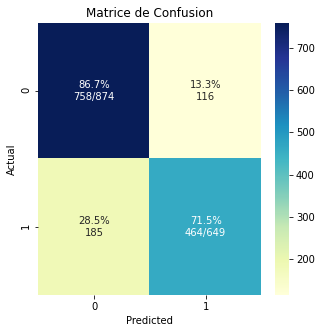

In [ ]:
### On affiche la matrice de confusion ###
clf_svm = SVC(C = 1.55,kernel="rbf", gamma = "scale", random_state = 1)
clf_svm.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_svm.predict(val_vectors_tfid),"Matrice de Confusion")

## Conclusion sur les modèles 

On remarque après avoir optimisé nos paramètres qu'on atteint une accuracy d'environ 80% maximum sur nos données. Cette précision ne tient pas compte de la façon dont nous extrayons les features et d'un quelconque nettoyage de la base de données que nous pourrions faire en amont. Nous verrons dans la prochaine partie que nous pouvons nettoyer la base de données pour réduire la taille du corpus d'apprentissage (et ainsi accélérer la phase d'apprentissage) mais également lui donner plus de sémantique. On peut privilégier un algorithme par rapport à l'autre en se demandant si notre priorité est de bien classer (en moyenne) les tweets qui sont des catastrophes, ou ceux qui n'en sont pas.

# 3. Extraction de features

Nous avons pour le moment utilisé deux modèles d'extraction de features que sont le **TF-IDF** qui pondèrent les mots du corpus (= ensemble de Tweets) en fonction de leur présence dans le corpus (TF pour Term Frequency) mais également du nombre de documents (= tweets) qui contiennent ce mot. La deuxième méthode, plus naïve, consiste uniquement à compter le nombre de représentants de chaque mot dans un corpus de texte. C'est donc une sous-méthode de TF-IDF. On peut retrouver plus d'informations sur TF-IDF [ici](https://0bc297c6-a-62cb3a1a-s-sites.googlegroups.com/site/caonmsu/ir/UsingTFIDFtoDetermineWordRelevanceinDocumentQueries.pdf?attachauth=ANoY7cofWF9JkPufNN2DDKkGGZ_aPdTugJDfwnXDgrw_nQUb7x7_SeOYZuQppFLARrOgMMl263LOCfiHBYorktnCXjDpaaOXMWGak0nxMjumRQ3RQEaOktWA4qxmXB-3r7pRIAcAxP_nUeLNyPYk3oKySzQ2lvRPYTWn4Av5luRHTPUj_Kb16yP9OdaCpyJKz4LUN5Jg1_r3_9FP_UFuCOb1HoT_4nmx2sFrvBC1jJ4m7OaCVO70pMDIZTiJ7FzYl6ZkCkBudTPH01R7vEmA4ZaRzVs0KUa-sw%3D%3D&attredirects=0).

In [ ]:
### Extraction du corpus de mots sur les 5 premiers tweets ###
vect =  CountVectorizer()
vect.fit_transform(X_train[:5])

<5x75 sparse matrix of type '<class 'numpy.int64'>'
	with 83 stored elements in Compressed Sparse Row format>

In [ ]:
### Affichage du corpus sur les 5 premiers tweets ###
print(vect.get_feature_names()[:20])

['1945', '670thescore', 'about', 'affect', 'alifaditha', 'amp', 'analysis', 'and', 'at', 'atomic', 'barackobama', 'became', 'blast', 'bomb', 'boycottbears', 'ca', 'cart', 'co', 'courageous', 'dampen']


Si l'on récupère les mots du corpus utilisés par cette méthode en ne considérant que les 5 premiers tweets on remarque que quasiment tous les mots ont un sens. On remarque cependant des "mots" comme "alifaditha" ou "boycottbears" qui semblent dénués de sens, et ce phénomène s'amplifie lorsqu'on regarde le corpus de tweet entier. Ceci est compréhensible : des liens / des mentions à d'autres utilisateurs ou des #hashtag peuvent être présents dans la base de données. Il est alors nécéssaire de nettoyer la base pour obtenir un corpus plus riche de sens. 

## Filtrer les liens

In [ ]:
### On trouve un text avec un lien ###
df_train["text"][246]

'U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/6LoJOoROuk via @Change'

Certains tweets incluent des liens, regardons la corrélation entre le fait qu'un tweet fait bien référence à un désastre et le fait qu'il contienne un lien.

In [ ]:
### Nouvelle feature indiquant si un tweet contient un lien
df_train["contains_an_url"] = 0
df_train.loc[df_train["text"].str.contains("http"), "contains_an_url"] = 1

In [ ]:
print("Coefficient de corrélation linéaire: ", np.corrcoef(df_train["contains_an_url"], df_train["target"])[0][1])

Coefficient de corrélation linéaire:  0.2474399184420561


Le coefficient de corrélation est non négligeable. Cela est peut-être dû au fait que certains tweets faisant référence à des désastres mentionnent des liens comme une source. On utilise donc une *feature* "le tweet contient un lien".
Afin de simplifier le traitement des tweets, on n'analyse pas les url et on les supprime des tweets.

In [ ]:
### Nouvelle feature avec le tweet sans url
df_train["urlfree_text"] = df_train["text"].apply(lambda x : re.sub(r"http\S+", "", x))

## Filter les hashtags

In [ ]:
### On cherche un tweet avec un # ###
df_train["text"][3]

'13,000 people receive #wildfires evacuation orders in California '

De même certains tweets incluent des hashtags, regardons la corrélation entre le fait qu'un tweet fait bien référence à un désastre et le fait qu'il contienne un hashtag.

In [ ]:
### Nouvelle feature indiquant si un tweet contient un hashtag
df_train["contains_hashtag"] = 0
df_train.loc[df_train["urlfree_text"].str.contains(r'#[^\s]+'), "contains_hashtag"] = 1

In [ ]:
print("Coefficient de corrélation linéaire: ", np.corrcoef(df_train["contains_hashtag"], df_train["target"])[0][1])

Coefficient de corrélation linéaire:  0.07339417313136051


Le coefficient de corrélation est plus faible que pour les liens, ce qui peut être expliqué par le fait que beaucoup de hashtags soient utlisés de manière générale. Créons plutôt une *feature* "le tweet contient un hashtag mentionné dans des tweets de désastres".

In [ ]:
### Liste des hashtags mentionnés dans les tweets de désastres
disasters_hashtags = []
compt = 0
for i, urlfree_tweet in df_train["urlfree_text"].items():
    if df_train["target"][i] == 1:
      list_h = re.findall('#[^\s]+', urlfree_tweet)
      for h in list_h:
        hashtag = '#'+ re.sub(r'[^\w\s]','', h[1:]) #enlève la ponctuation du hashtag
        if hashtag not in disasters_hashtags:
          disasters_hashtags.append(hashtag)

In [ ]:
### Expression régulière pour tester si un tweet contient un des hashtags
reg_h = disasters_hashtags[0]
for i in range(1, len(disasters_hashtags)):
  reg_h += '|' + disasters_hashtags[i]

In [ ]:
df_train["contains_disasters_hashtag"] = 0
df_train.loc[df_train["urlfree_text"].str.contains(reg_h), "contains_disasters_hashtag"] = 1

In [ ]:
print("Coefficient de corrélation linéaire: ", np.corrcoef(df_train["contains_disasters_hashtag"], df_train["target"])[0][1])

Coefficient de corrélation linéaire:  0.07448643296246488


Le coefficient de corrélation reste faible, il se peut que beaucoup des hashtags mentionnés dans les tweets de désastres soient aussi utilisés dans les tweets normaux. 

Supprimons les # des hashtags des tweets (on garde la suite du hashtag comme un mot). Cela peut en effet faire apparaître des mots clés pour la classification des tweets.

In [ ]:
### Nouvelle feature avec le tweet sans url sans hashtag
df_train["hashtag_urlfree_text"] = df_train["urlfree_text"].apply(lambda x : re.sub(r'#', "", x))

In [ ]:
df_train["hashtag_urlfree_text"][3]

'13,000 people receive wildfires evacuation orders in California '

## Retirer les mentions à des utilisateurs

In [ ]:
### On trouve un text avec un tag ###
df_train["text"][246]

'U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/6LoJOoROuk via @Change'

Certains tweets incluent des tags (mentions à des utilisateurs), regardons la corrélation entre le fait qu'un tweet fait bien référence à un désastre et le fait qu'il contienne un tag.

In [ ]:
### Nouvelle feature indiquant si un tweet contient un tag
df_train["contains_tag"] = 0
df_train.loc[df_train["hashtag_urlfree_text"].str.contains(r'@[^\s]+'), "contains_tag"] = 1

In [ ]:
print("Coefficient de corrélation linéaire: ", np.corrcoef(df_train["contains_tag"], df_train["target"])[0][1])

Coefficient de corrélation linéaire:  -0.11966847465994246


Le coefficient de corrélation négatif peut être expliqué par le fait que beaucoup de tweets normaux utilisent des tags.

Retirons les mentions à des utilisateurs.

In [ ]:
### Nouvelle feature avec le tweet sans url sans mentions
df_train["tag_hashtag_urlfree_text"] = df_train["hashtag_urlfree_text"].apply(lambda x : re.sub(r'@[^\s]+','', x))

In [ ]:
df_train["tag_hashtag_urlfree_text"][246]

'U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse...  via '

In [ ]:
### On compte maintenant le nombre de feature après extraction du corpus ###
vect = CountVectorizer(encoding="unicode", analyzer="word", lowercase=False)
vect.fit_transform(df_train["tag_hashtag_urlfree_text"])
feature = vect.get_feature_names()
print(len(feature))

18953


## Dictionnaire

Les tweets ne parlant pas de catastrophe du tout peuvent être facilement catégorisés en 0. Afin de repérer un tweet qui ne parle pas du tout de catastrophes, on peut regarder si il emploie des mots du registre lexical de la catastrophe, avec dans l’idée que ce registre est relativement réduit. Cela devrait permettre d’éviter quelques faux positifs.

Nous avons donc trouvé sur internet un corpus de 69 mots du registre de la catastrophe. Nous analysons pour chaque tweet si un de ces mots appartient à ce corpus à quelques fautes d’orthographe près (donc à une distance d’édition faible).  

Le principe marche relativement mal : on pourrait sensiblement améliorer ce modèle en construisant un liste de mots plus grande et exhaustive, cependant l’intérêt pour nous est limité. Cependant une entreprise comme Twitter pourrait tout à fait construire une telle liste, car comparer chaque mot d’un tweet à quelques centaines de mots est relativement gérable. 

A l’inverse, on pourrait consituer un corpus de mots associés à des fake news tels que "inside job" ou "chemtrails". Une bonne extension de ce modèle serait d’attribuer une probabillité d’appartenance basée sur ces mots.

In [ ]:
words_catastrophy = ['tsunami', 'natural disasters', 'volcano', 'tornado', 'avalanche', 'earthquake', 'blizzard', 'drought', 'bushfire', 'tremor', 'dust storm', 'magma', 'twister', 'windstorm', 'heat wave', 'cyclone', 'forest fire', 'flood', 'fire', 'hailstorm', 'lava', 'lightning', 'high-pressure', 'hail', 'hurricane', 'seismic', 'erosion', 'whirlpool', 'Richter scale', 'whirlwind', 'cloud', 'thunderstorm', 'barometer', 'gale', 'blackout', 'gust', 'force', 'low-pressure', 'volt', 'snowstorm', 'rainstorm', 'storm', 'nimbus', 'violent storm', 'sandstorm', 'casualty', 'Beaufort scale', 'fatal', 'fatality', 'cumulonimbus', 'death', 'lost', 'destruction', 'money', 'tension', 'cataclysm', 'damage', 'uproot', 'underground', 'destroy', 'arsonist', 'wind scale', 'arson', 'rescue', 'permafrost', 'disaster', 'fault', 'scientist', 'shelter']

100%|██████████| 6089/6089 [03:16<00:00, 30.93it/s]


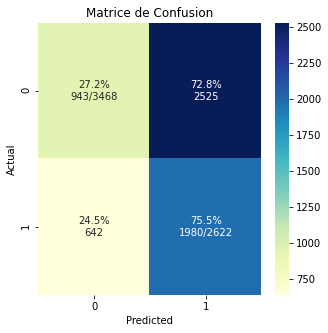

In [ ]:
Y_train_predict = np.ones(len(X_train))
Z = X_train_free.to_numpy()

for i in tqdm(range(1,len(X_train))):
  counter = 0
  for word in Z[i,0].split():
    for catastrophy_word in words_catastrophy:
      if(nltk.edit_distance(word,catastrophy_word)<3):
        counter += 1
  if(counter == 0):
    Y_train_predict[i] = 0
# print(confusion_matrix(y_train,Y_train_predict))
plot_cm(y_train,Y_train_predict,"Matrice de Confusion")

In [ ]:
Y_train_predict = np.ones(len(X_train))
Z = X_train_free.to_numpy()

In [ ]:
# On montre les valeurs où Y_train_preduct vaut 0 et y_train vaut 1
a=(Y_train_predict + 1)*(y_train + 3) == 4
print(Z[a])

[]


## LSA
Latent Semantic Analysis (LSA) est une méthode d'analyse du langage permettant d'extraire des thèmes d'un corpus de textes (ici les tweets).

LSA fait l'hypothèse distributionnelle : les mots proches en sens sémantique sont utilisés dans des documents proches en thème (topic) sémantique. Pour citer wikipédia,  
"A matrix containing word counts per document (rows represent unique words and columns represent each document) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns. Documents are then compared by taking the cosine of the angle between the two vectors (or the dot product between the normalizations of the two vectors) formed by any two columns. Values close to 1 represent very similar documents while values close to 0 represent very dissimilar documents."  

On va donc utiliser cet algorithme pour extraire des topics dans notre corpus de tweets. Ces topics fournissent des features, au même titre que les mots. Nous nous sommes appuyés sur ce site [ici](https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python).

On va appliquer le modèle LSA

In [ ]:
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Preprocessing Data  
After data loading function, you need to preprocess the text. Following steps are taken to preprocess the text:



1.   Tokenize the text articles
2.   Remove stop words
3.   Perform stemming on text article






In [ ]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i[0].lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

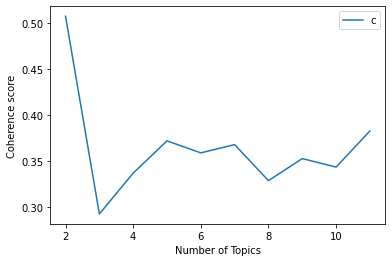

In [ ]:
start,stop,step=2,12,1
clean_text = preprocess_data(Z)
plot_graph(clean_text,start,stop,step)

On voit que 2 sujets permettent d'avoir un bien meilleur fit avec les données ; on va donc passer en hyperparamètre 2 sujets principaux, qui auront logiquement une corrélation avec le sujet de notre recherche.

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
# LSA Model
number_of_topics=2
words=10
document_list = Z
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
print(model)

[(0, '0.366*"amp" + 0.351*"like" + 0.282*"fire" + 0.217*"û_" + 0.179*"get" + 0.164*"2" + 0.129*"bomb" + 0.118*"new" + 0.115*"video" + 0.113*"peopl"'), (1, '0.563*"like" + -0.335*"û_" + -0.271*"bomb" + 0.241*"amp" + -0.215*"suicid" + -0.169*"kill" + -0.149*"fire" + -0.141*"bomber" + 0.132*"get" + -0.128*"old"')]
LsiModel(num_terms=10377, num_topics=2, decay=1.0, chunksize=20000)


On a découvert donc 2 topics. Ces topics ne correspondent pas forcément à "fake disasters", mais on peut remarquer dans les "mots" ayant une grosse influence des mots lourds de sens, parlant de mort, etc, ainsi que d'autres plus obscurs, qui sont probablement des facteurs de confusion, comme les nombres. Nous avons cependant évalué qu'il était très difficile de traiter les nombres, étant donnée la multitude de formats (13 000, treize mille, 13k, 13 k...).  
Une autre surprise a été l'importance de 'amp', qui est le nom d'une agence de presse belge, mais aussi... le code HTML de l'esperluette. Ces symboles, présents dans url mais pas que, sont des *facteurs de confusion* : des données réparties aléatoirement dans les tweets qui perturbe nos algorithmes.

## Modèles avec ces nouvelles *features*

Nous allons maintenant entrainer à nouveau nos deux algorithmes (Ridge et la machine à noyeaux gaussien) avec notre base de données nettoyées. Nous allons ainsi voir si nos intuitions étaient bonnes lorsque nous avons forgé nos features artificielles.

Commençons par préparer nos données

In [ ]:
### On teste notre Ridge precécédant sur cette base purgée de vecteurs inutiles. On garde pour le moment les mêmes paramètres d'entrainement.
X_train_free, X_val_free, y_train_free, y_val_free = train_test_split(df_train[['tag_hashtag_urlfree_text', 'contains_an_url', 'contains_disasters_hashtag', 'contains_tag']], df_train["target"], test_size=0.2, random_state=42)

In [ ]:
### On transforme nos données ###
tfid_vectorizer = TfidfVectorizer()
tfid_vectorizer.fit(X_train_free["tag_hashtag_urlfree_text"])
train_vectors_tfid_free = tfid_vectorizer.transform(X_train_free["tag_hashtag_urlfree_text"])
val_vectors_tfid_free = tfid_vectorizer.transform(X_val_free["tag_hashtag_urlfree_text"])

In [ ]:
### On ajoute nos features après traitement de la base de données ###
train_vectors_tfid_free = hstack((X_train_free["contains_tag"].to_numpy()[:,np.newaxis],X_train_free["contains_disasters_hashtag"].to_numpy()[:,np.newaxis],X_train_free["contains_an_url"].to_numpy()[:,np.newaxis],train_vectors_tfid_free))
val_vectors_tfid_free = hstack((X_val_free["contains_tag"].to_numpy()[:,np.newaxis],X_val_free["contains_disasters_hashtag"].to_numpy()[:,np.newaxis],X_val_free["contains_an_url"].to_numpy()[:,np.newaxis],val_vectors_tfid_free))

### Ridge

On teste un gridsearch pour trouver les paramètres adéquats sur Ridge. On effectue pour cela plusieurs balayages successifs pour trouver une valeur maximisant l'accuracy.

In [ ]:
parameters = {'alpha':np.arange(0.5,20,0.1)}
ridge = linear_model.RidgeClassifier()
clf_ridge = GridSearchCV(ridge, parameters, scoring="accuracy", cv=2)
### On lance la gridsearch ###
clf_ridge.fit(train_vectors_tfid_free, y_train_free)
### Meilleure alpha ###
print("Le meilleur paramètre est {} pour une précision de {}".format(clf_ridge.best_params_,clf_ridge.best_score_))

Le meilleur paramètre est {'alpha': 1.4999999999999998} pour une précision de 0.7894909688013136


In [ ]:
parameters = {'alpha':np.arange(1,2,0.01)}
ridge = linear_model.RidgeClassifier()
clf_ridge = GridSearchCV(ridge, parameters, scoring="accuracy", cv=2)
### On lance la gridsearch ###
clf_ridge.fit(train_vectors_tfid_free, y_train_free)
### Meilleure alpha ###
print("Le meilleur paramètre est {} pour une précision de {}".format(clf_ridge.best_params_,clf_ridge.best_score_))

Le meilleur paramètre est {'alpha': 1.4200000000000004} pour une précision de 0.7894909688013136


In [ ]:
parameters = {'alpha':np.arange(1.45,1.55,0.001)}
ridge = linear_model.RidgeClassifier()
clf_ridge = GridSearchCV(ridge, parameters, scoring="accuracy", cv=2)
### On lance la gridsearch ###
clf_ridge.fit(train_vectors_tfid_free, y_train_free)
### Meilleure alpha ###
print("Le meilleur paramètre est {} pour une précision de {}".format(clf_ridge.best_params_,clf_ridge.best_score_))

Le meilleur paramètre est {'alpha': 1.494999999999995} pour une précision de 0.789655172413793


In [ ]:
### On entraine notre classifier Ridge ###
clf_ridge = linear_model.RidgeClassifier(alpha=1.489)
clf_ridge.fit(train_vectors_tfid_free, y_train_free)
print("L'accuracy sur les données de validations est : ",accuracy_score(clf_ridge.predict(val_vectors_tfid_free), y_val_free))

L'accuracy sur les données de validations est :  0.8115561391989494


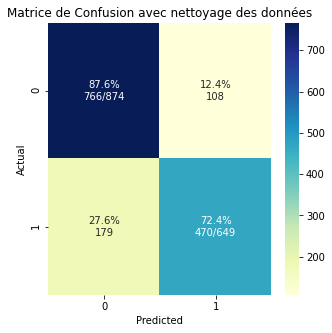

In [ ]:
### On affiche la matrice de confusion ###
clf_ridge = linear_model.RidgeClassifier(alpha=1.489)
clf_ridge.fit(train_vectors_tfid_free, y_train_free)
plot_cm(y_val_free,clf_ridge.predict(val_vectors_tfid_free),"Matrice de Confusion avec nettoyage des données")

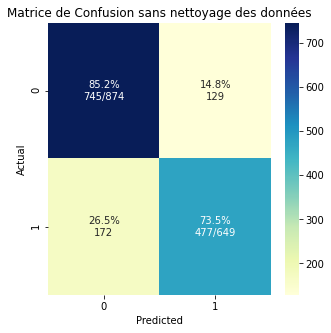

In [ ]:
### On affiche la matrice de confusion ###
clf_ridge = linear_model.RidgeClassifier(alpha=1.606)
clf_ridge.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_ridge.predict(val_vectors_tfid),"Matrice de Confusion sans nettoyage des données")

Nous trouvons ainsi un score de 81.2% avec nos nouvelles features, soit une augmentation de 1.4 points par rapport à notre optimisation de départ. Nos nouvelles features permettent donc à l'algorithme de véritablement mieux s'approprier les données qu'il observe ! On remarque que nos nouvelles features permettent de mieux gérer les tweets non catastrophiques (qui sont majorataires sur notre exemple de validation) au prix d'une performance moins élevée sur les tweets catastrophiques. Voyons maintenant ce qu'il en est pour notre second algorithme :

### Machine à noyaux

Nous lançons encore une fois des grid-searchs de plus en plus fins pour optimiser notre modèle.

In [ ]:
parameters = {'C':np.arange(0.5,5,0.5)}
svm = SVC(kernel="rbf", gamma = "scale", random_state = 1)
grid_svc = GridSearchCV(svm, parameters, scoring="accuracy", cv=2)
grid_svc.fit(train_vectors_tfid_free, y_train_free)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_svc.best_params_,grid_svc.best_score_))

Le meilleur paramètre est {'C': 3.0} pour une précision de 0.7819376026272578


In [ ]:
parameters = {'C':np.arange(2.5,3.5,0.1)}
svm = SVC(kernel="rbf", gamma = "scale", random_state = 1)
grid_svc = GridSearchCV(svm, parameters, scoring="accuracy", cv=2)
grid_svc.fit(train_vectors_tfid, y_train)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_svc.best_params_,grid_svc.best_score_))

Le meilleur paramètre est {'C': 2.8000000000000003} pour une précision de 0.7847290640394089


In [ ]:
parameters = {'C':np.arange(2.7,2.9,0.01)}
svm = SVC(kernel="rbf", gamma = "scale", random_state = 1)
grid_svc = GridSearchCV(svm, parameters, scoring="accuracy", cv=2)
grid_svc.fit(train_vectors_tfid, y_train)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_svc.best_params_,grid_svc.best_score_))

Le meilleur paramètre est {'C': 2.71} pour une précision de 0.7847290640394089


In [ ]:
parameters = {'C':np.arange(2.70,2.73,0.001)}
svm = SVC(kernel="rbf", gamma = "scale", random_state = 1)
grid_svc = GridSearchCV(svm, parameters, scoring="accuracy", cv=2)
grid_svc.fit(train_vectors_tfid, y_train)
print("Le meilleur paramètre est {} pour une précision de {}".format(grid_svc.best_params_,grid_svc.best_score_))

Le meilleur paramètre est {'C': 2.708999999999999} pour une précision de 0.7847290640394089


In [ ]:
### On entraine notre classifier Ridge ###
clf_svm = SVC(C = 2.708,kernel="rbf", gamma = "scale", random_state = 1)
clf_svm.fit(train_vectors_tfid_free, y_train_free)
print("L'accuracy sur les données de validations est : ",accuracy_score(clf_svm.predict(val_vectors_tfid_free), y_val_free))

L'accuracy sur les données de validations est :  0.8023637557452397


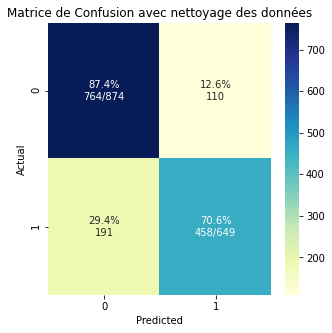

In [ ]:
### On affiche la matrice de confusion ###
clf_svm = SVC(C = 2.708,kernel="rbf", gamma = "scale", random_state = 1)
clf_svm.fit(train_vectors_tfid_free, y_train_free)
plot_cm(y_val_free,clf_svm.predict(val_vectors_tfid_free),"Matrice de Confusion avec nettoyage des données")

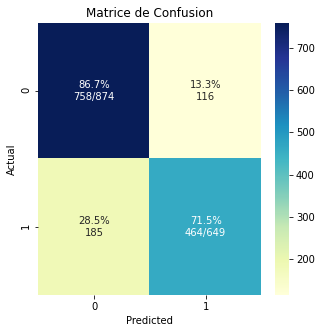

In [ ]:
### On affiche la matrice de confusion ###
clf_svm = SVC(C = 1.55,kernel="rbf", gamma = "scale", random_state = 1)
clf_svm.fit(train_vectors_tfid, y_train)
plot_cm(y_val,clf_svm.predict(val_vectors_tfid),"Matrice de Confusion")

Ici encore, nous améliorons nos performances par rapport à l'entrainement sur la base de données non nettoyée. On remarque le même phénomène que précédement : avec notre ajout de features nos algorithmes sont plus robustes sur la classification de tweets non désastreux. Nous augmentons ainsi de 0.4 points notre précision grâce à ces nouvelles features ! L'augmentation est certe plus faible que la précédente mais reste tout de même conséquente.

# 4. LSTM

Nous allons explorer une autre méthode d'apprentissage pour tenter d'améliorer nos prédictions. Nous allons mettre en place un certain type d'architecture de réseau récurrent, aussi connu sous le nom de LSTM dont on peut trouver les détails [ici](https://www.isca-speech.org/archive/archive_papers/interspeech_2012/i12_0194.pdf).

Pour extraire les features de notre text, nous prenons le partie de tester 2 nouvelles techniques : un modèle pré-entrainé avec GloVe et un embedding layer que l'on entrainera.

Dans un premier temps, nous implémentons une partie utilisant l'algorithme GloVe (Global Vectors for Word Representation) que l'on retrouve [ici](https://nlp.stanford.edu/projects/glove/). Nous prenons un modèle pré-entrainé sur un large corpus de 2 milliards de tweets qui contient environ 27 milliards de mots de vocabulaire différents. 

In [ ]:
### Installation de l'api glove pour python ###
! pip install glove_python

     |████████████████████████████████| 266kB 5.0MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700247 sha256=d3d41920d3b1053133b5a2afa158166ee49ec40d479319ea4cd85f95c901018d
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [ ]:
### Importation de l'API python de GloVe ###
import glove

In [ ]:
### Téléchargement du modèle pré-entrainé
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-05-29 18:16:32--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-05-29 18:16:32--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-05-29 18:16:32--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
### Préparation de notre modèle pré-entrainé ###
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


On peut maintenant donner les paramètres de notre modèle d'extraction de features. Au vu de la petite taille de notre corpus, nous nous donnons au maximum MAX_NB_WORDS mots pour extraire les features. Les tweets étant également très courts, nous supposons qu'ils ne font pas plus de MAX_SEQUENCE_LENGTH mots (i.e. 30 dans notre cas). Nous décidons également de représenter un mot par un vecteur de taille EMBEDDING_DIM vallant 50, cette valeur étant fixée par notre modèle pré-entrainé. 

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 25000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 30 
# This is fixed.
EMBEDDING_DIM = 50 # fixed by GloVe

On récupère les bases de données nettoyées de la partie précédente pour appliquer nos algorithmes : on retire au minimum les urls (qui ne seront jamais prèsent dans notre modèle pré-entrainé) ainsi que les références @pseudo.

In [ ]:
df_train_urlfree = df_train["text"].apply(lambda x : re.sub(r"http\S+", "", x))
df_train_at_free = df_train_urlfree.apply(lambda x : re.sub('@[^\s]+','',x))

On transforme nos tweets en séquences d'entrée en découpant chaque mot et en lui associant une unique clé entière.

In [ ]:
# split and tokenize data (we remove special characters)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters="!'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n", lower=True, split = " ")
tokenizer.fit_on_texts(df_train_at_free)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(df_train_at_free)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df_train["target"]).values
print('Shape of label tensor:', Y.shape)

Found 15116 unique tokens.
Shape of data tensor: (7613, 30)
Shape of label tensor: (7613, 2)


On découpe ensuite notre base de données pour entrainer notre réseau sur 80% de la base et garder 20% pour mesurer en mesurer les performances. On prend soin de garder le même état aléatoire pour refaire une découpe similaire à celle faite au début.

In [ ]:
X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(X,Y, test_size = 0.2, random_state = 42)

On charge la matrice de correspondance de notre modèle pre-entrainé. Cette matrice fait le lien entre un mot comme "hello" identifié par un entier et sa représentation sous forme d'un vecteur de dimension 50.

In [ ]:
### On charge la matrice d'embedding et on affiche la représentation vectorielle du mot "hello" ### 
word_embedding = glove.Glove.load_stanford("glove.twitter.27B.50d.txt")
word_embedding.word_vectors[word_embedding.dictionary["hello"]]

array([ 0.28751  ,  0.31323  , -0.29318  ,  0.17199  , -0.69232  ,
       -0.4593   ,  1.3364   ,  0.709    ,  0.12118  ,  0.11476  ,
       -0.48505  , -0.088608 , -3.0154   , -0.54024  , -1.326    ,
        0.39477  ,  0.11755  , -0.17816  , -0.32272  ,  0.21715  ,
        0.043144 , -0.43666  , -0.55857  , -0.47601  , -0.095172 ,
        0.0031934,  0.1192   , -0.23643  ,  1.3234   , -0.45093  ,
       -0.65837  , -0.13865  ,  0.22145  , -0.35806  ,  0.20988  ,
        0.054894 , -0.080322 ,  0.48942  ,  0.19206  ,  0.4556   ,
       -1.642    , -0.83323  , -0.12974  ,  0.96514  , -0.18214  ,
        0.37733  , -0.19622  , -0.12231  , -0.10496  ,  0.45388  ])

Il convient maintenant de relier notre modèle pré-entrainé aux séquences que nous avons implémentés plus haut. En effet, on possède une matrice word_embedding qui relie un mot identifié par un entier à un vecteur de dimension 50 grâce à l'algorithme GloVe. On possède également une correspondance entre chaque mot de tweet et un entier grâce à notre pré-traitement en séquence. Il faut ainsi relier les identifiants des mots issus des séquences aux identifiants des mots issus de notre modèle pré-entrainé, ce que nous faisons maintenant

In [ ]:
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM)) 
j = 0
words_not_found = []
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try : 
      embedding_vector = word_embedding.word_vectors[word_embedding.dictionary[word]]
    except KeyError:
      embedding_vector = None
      words_not_found.append(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("Il y a {} mots qui n'ont pas été trouvé dans le vocabulaire de notre modèle GloVe, voici un extrait de ces mots : ".format(len(words_not_found)))
print(words_not_found[:20])

Il y a 2773 mots qui n'ont pas été trouvé dans le vocabulaire de notre modèle GloVe, voici un extrait de ces mots : 
['2', '3', '1', '4', '5', '2015', 'mh370', '8', '11', '\x89û', '9', '6', '15', '10', '08', '7', '70', '40', '\x89ûò', '30']


On remarque ici que nous avons 2773 mots dans nos tweets qui ne sont pas dans notre modèle pré-entrainé. On perd donc de l'information sur notre base de données et sur nos tweets, mais on gagne en rapidité sur l'entraînement de notre modèle LSTM. Les mots qui ne se trouvent pas dans le vocabulaire sont majoritairement des nombres et également des mots sans aucun sens, comme "mh370" ou "\x89û" qui proviennent de l'encodage de certains signes, comme &, dans la base de données, ou d'un numéro de vol.

On propose maintenant deux modèles de LSTM. Le premier utilise le modèle pré-entrainé avec GloVe et le second utilise un Embedding Layer pour apprendre lui même la meilleure répresentation possible des mots du corpus.

In [ ]:
### Modèle LSTM classique ###
def get_model(X):
  model = Sequential()
  EMBEDDING_DIM = 30
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = X.shape[1]))
  #we ignore all the zeros values (irrelevant for treatement)
  model.add(Masking(0.0))
  #drop out to reduce overfit
  model.add(SpatialDropout1D(0.2))
  #once the data preprocessed, we can then apply the LSTM Network
  model.add(LSTM(EMBEDDING_DIM, dropout=0, recurrent_dropout=0)) 
  model.add(Dense(2, activation = "sigmoid")) #fully connected layer (only two classes therefore use sigmoid function as activation)
  #we use a binary cross entropy loss as the problem is a two-classes classification
  model.compile(loss = binary_crossentropy, optimizer='adam', metrics=["accuracy"])
  print(model.summary())
  return model

In [ ]:
### Modèle LSTM utilisant une couche pré-entrainée avec GloVe ###
def get_model_glove(X):
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS,
              EMBEDDING_DIM,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False))
  #we ignore all the zeros values (irrelevant for treatement)
  model.add(Masking(0.0))
  model.add(LSTM(EMBEDDING_DIM, dropout=0.1, recurrent_dropout=0.1))  
  model.add(Dense(50, activation = "relu"))
  model.add(Dense(2, activation = "sigmoid")) #fully connected layer (only two classes therefore use sigmoid function as activation)
  #we use a binary cross entropy loss as the problem is a two-classes classification
  model.compile(loss = binary_crossentropy, optimizer='adam', metrics=["accuracy"])
  print(model.summary())
  return model

On s'intéresse maintenant à l'entrainement de nos réseaux de neurones. On commence par entrainer notre réseau de neurone avec notre modèle pré-entrainé GloVe.

In [ ]:
model = get_model_glove(X)
epochs = 20
batch_size = 32

history = model.fit(X_train_lstm, Y_train_lstm, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience = 10, min_delta = 0.01,restore_best_weights=True)])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 50)            1250000   
_________________________________________________________________
masking_4 (Masking)          (None, 30, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 102       
Total params: 1,272,852
Trainable params: 22,852
Non-trainable params: 1,250,000
_________________________________________________________________
None
Epoch 1/20
172/172 [==============================] - 9s 50ms/step - loss: 0.5162 - accuracy: 0.7577

In [ ]:
accr = model.evaluate(X_test_lstm,Y_test_lstm)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.6f}'.format(accr[0],accr[1]))

48/48 [==============================] - 0s 7ms/step - loss: 0.4241 - accuracy: 0.8162
Test set
  Loss: 0.424
  Accuracy: 0.816152


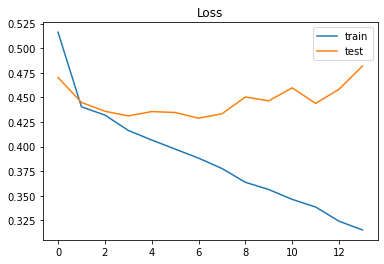

In [ ]:
### Affichage de la loss en fonction des epochs ###
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

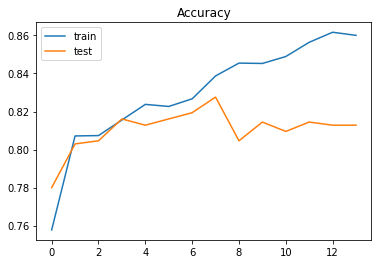

In [ ]:
### Affichage de l'accuracy en fonction des epochs ###
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

On remarque que le réseau overfit après quelques épochs, et ce malgré le nombre faible de paramètres entrainables dans notre réseau : environ 22 000. L'accuracy est plus élevée qu'avec les algorithmes que nous avions développés en début de partie, avec environ 81.6% de précision. 

Nous allons maintenant comparer cette valeur à l'entrainement de notre second réseau de neurones qui n'utilise pas GloVe.

In [ ]:
model = get_model(X)
epochs = 20
batch_size = 32

history = model.fit(X_train_lstm, Y_train_lstm, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience = 10, min_delta = 0.01,restore_best_weights=True)])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 30)            750000    
_________________________________________________________________
masking_6 (Masking)          (None, 30, 30)            0         
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 30)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 62        
Total params: 757,382
Trainable params: 757,382
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
172/172 [==============================] - 7s 40ms/step - loss: 0.5999 - accuracy: 0.6712 - val_lo

In [ ]:
accr = model.evaluate(X_test_lstm,Y_test_lstm)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.6f}'.format(accr[0],accr[1]))

48/48 [==============================] - 0s 5ms/step - loss: 0.4455 - accuracy: 0.8050
Test set
  Loss: 0.445
  Accuracy: 0.804990


On remarque que ce second réseau overfit bien plus rapidement, malgré le dropout que nous avions implémenté. L'accuracy est également moins importante, mais reste tout de même meilleure que certaines des méthodes que nous avions implémentées.

# 5. Conclusion

Nous avons voulu explorer les grandes méthodes de NLP afin de mieux comprendre l'état de l'art dans le sujet. Pour ce faire, nous avons implémenté les méthodes de Ridge Classification, Boosting Trees, Machines à Noyaux et Random Forest. Ces différents modèles donnent déjà, sans extractions de features des résultats encourageant, de l'ordre de 78% d'accuracy. Nous avons ensuite tunés ces modèles en réalisant un travail de nettoyage sur les données. Cela nous a permis de pousser les modèles à leur limite.

Pour augmenter notre score, il nous fallait donc augmenter l'information disponible. Nous avons donc retiré les informations non sémantiquement utiles et tenté d'extraire d'autres mots clés contenus dans les hashtags et url. Ces méthodes nous ont permis de gagner encore 1 point d'accuracy en moyenne.

Nous avons ensuite exploré une dernière méthode utilisantun réseau de neurones récurrent (LSTM) ainsi qu'un modèle pré-entrainé (GloVe). Ce dernier nous a permis d'atteindre la meilleure accuracy, à 81.5%. Pour aller plus loin, nous aurions pu par exemple mieux analyser les features dans les tweets, notamment les indicateurs chiffrés et faire de la correction orthographique pour déterminer le sens de certains mots mal écrits. Certaines équipes sont parvenues à atteindre des accuracy entre 99 et 100%. Ces ajouts pourraient nous permettre d'augmenter davantage les performances du classifier (F1-score de 1).